In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import pandas as pd 

from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

from scipy.optimize import curve_fit
import scipy.stats as stat
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
from scipy.misc import electrocardiogram

In [11]:
def GetImage(fitfile): 
    '''Takes: .fit file
        Returns: file, data  (n,m) for n rows and m colums, file info '''
    file = get_pkg_data_filename(fitfile)
    image_data = fits.getdata(file, ext = 0)
    return file, image_data, fits.info(file)


    

def PlotRings(image_data, title, xlabel, ylabel): 
    '''Specifics for Ploting Ring image'''
    # Style
    plt.style.use(astropy_mpl_style)
    # plt.style.use('bmh')
    hfont = {'fontname':'Consolas'}
    fig, axes = plt.subplots(figsize= (8,6))

    #plot
    axes.imshow(image_data, cmap = 'gray', norm= colors.PowerNorm(gamma=0.5))

    #labels 
    axes.set_title(title, **hfont)
    axes.set_ylabel(ylabel, **hfont)
    axes.set_xlabel(xlabel, **hfont)
    plt.gca().invert_yaxis()
    return




def CreateData(txtfilename):
    ''' Takes: .txt file
        Returns: arrays: x,y = Bins, Intensities'''
    #Declare lists  
    bins = []
    intensities = []
    #read file
    f = open(txtfilename, 'r')
    #loop and campartmentaize 
    for row in f: 
        row = row.split()
        bins.append(int(row[0]))
        intensities.append(int(row[1]))
    return bins, intensities






def Plots(x, y, title, xlabel, ylabel, xrange = [ -1 , -1 ] , yrange = [ -1 , -1 ]):
    '''Plots anything but plots Intensities really well'''
    #style plot
    fig, axes = plt.subplots(figsize= (10,4))
    plt.style.use(astropy_mpl_style)
    hfont = {'fontname':'Consolas'}

    if yrange == [ -1 , -1 ] :
        yspan = max(y) - min(y)
        yrange =[ min(y) - yspan/10. , max(y) + yspan/10. ]
    if xrange == [ -1 , -1 ] :
        xspan = max(x) - min(x)
        xrange = [ min(x) - xspan/10. , max(x) + xspan/10. ]

    #plot
    axes.plot(x, y, label= 'File Data', color='blue')

    #labels 
    axes.set_title(title, **hfont)
    axes.set_ylabel(ylabel, **hfont)
    axes.set_xlabel(xlabel, **hfont)
    return 




def SaveFigure(filename):
    '''If you forget the keyword'''
    plt.savefig(filename, bbox_inches ='tight' )
    return




def LabelPeaks_ShrinkData( xvalues, yvalues, lowerxlim, upperxlim, lowerylim): 
    ''' Takes: Original bulk data (x,y) and limits to truncate the data
        Returns: The desired peaks and the truncated data (xnew,ynew)'''
    #Find bin x-values to associated local y-Max values
    peaks, _ = find_peaks(yvalues, distance=25)

    #Label the associated y-Max values
    all_ymax = yvalues[peaks]

    #forloop/zip: This applies the truncation on the Peak values ONlY
    #For p value our zip set (bin,intensity)
    #if: select the range of peaks we want
    #and: select the limit of intensity values
    tru_peaks = [p for (p,y) in zip(peaks,all_ymax) if ((p >= lowerxlim and p<= upperxlim) and y >= lowerylim)]

    # Truncate the data to make the peak values 
    new_yvalues =[]
    new_xvalues =[]
    for n in xvalues: 
        if n >= lowerxlim and n <= upperxlim:
            new_xvalues.append(n)
            new_yvalues.append(yvalues[n])
        else: 
            continue
    return tru_peaks, new_xvalues, new_yvalues




def PlotNewPeaks(newpeaks, OG_intensities ):
    '''Just a specific way to plot the Peaks with a red (x)'''
    plt.plot(newpeaks, OG_intensities[newpeaks], 'x', color ='red')
    return




def gaussian( x , *p ) :
    return np.absolute( p[0] ) * np.exp( -( x - p[1] )**2/( 2*p[2]**2 ) )


def ZeemanPeakfit(x, *p): 
    '''Attempting with only one Gaussian - anything greater made sifting harder'''
    return  gaussian( x , *p[0:3] )  

# + gaussian( x , *p[3:6] ) + gaussian( x , *p[6:9] ) + gaussian( x , *p[9:12] ) + gaussian( x , *p[12:15] ) + gaussian( x , *p[15:18] ) + gaussian( x , *p[18:21] ) + gaussian( x , *p[21:24] )

def PeakBinValuesbyfit(fitfunction, newx, newy, NewPeaks, OG_intensity, AmpAdjust, ShiftAdjust, p0 = 1):
    ''' Takes: Fitfunction, the new data (xnew,ynew), the original yvalues, 
                our small adjustments of Amp and x-shift
        Returns: Parameters for all fitGausians and the mean bin location of our peaks 
                    This is the mean parameter of our gaussian'''
    #convert list to array 
    peak = np.array(NewPeaks)
    #empty array becomes out initial guesses for the fit
    p = np.zeros(len(peak)*3)
    #counter
    if p0 == 1:
        print('Default input parameters chosen: random')
        n = 0 
        for i in range(len(peak)):
            #Amp
            p[n] = OG_intensity[peak][i] + AmpAdjust
            #Shift
            p[n+1] = peak[i]+ShiftAdjust
            #factor
            p[n+2] = np.random.uniform(0.6,0.9)
            # print(p[n+2])
            n += 3
    elif p0 != 1: 
            p[2] = p0[0]
            p[5] = p0[1]
            p[8] = p0[2]
            p[11] = p0[3]
            p[14] = p0[4]
            p[17] = p0[5]
            p[20] = p0[6]
            p[23] = p0[7]
    print(p)
    #fit 
    # sigma = np.random.uniform(100,200, len(newy))
    popt , pcov = curve_fit( fitfunction, newx, newy, p0 = p, absolute_sigma=True, maxfev=2000)

    #Paramerters of our gaussians 
    popt1 = np.array(popt)
    #Take the 2nd term of each set of 3 
    peakbinvalues = []
    for i in range(1, len(popt), 3): 
        peakbinvalues.append(popt[i])

    return popt, peakbinvalues




def RadiusValuesInner_to_Outer(peakbinsvalues):
    ''' Takes: final desired Bin-Peak locations
        Returns: radius values from the inner peak to the outer peak
                 in micro-meters'''
    start = 0
    end = len(peakbinsvalues) - 1
    diameter = []
    while start < end:
        # Create pairs taking from the start and the end of the list
        pair = (peakbinsvalues[start], peakbinsvalues[end])
        # take their difference 
        diameters = abs(pair[0] - pair[1])
        # Round
        d = np.round(diameters, decimals=3)
        diameter.append(d)
        # iterate 
        start += 1
        end -= 1
    #list to array - this list is diameters from the outer rings to the inner rings
    diameter = np.array(diameter)
    #convert to radius
    radius = diameter/2
    #reverse the order: inner ring is now first 
    radius = radius[::-1]
    #convert to micrometer (per pixel) is (9um x 9um)
    radius_micometer = radius*9
    return radius_micometer 

# Steps 
- GetImage
> file, file_data, file_info
- PlotRings
- CreateData
- MakeArrays
> (x,y) = (bins, intensities)
- Plots (General Idea)
- LabelPeaks_ShrinkData
> Shrink to the amount of peaks of interest by setting limits 
>> True peaks, New x data, New ydata
- Plots (new range)
- PlotNewPeaks (desired peak values)
- PeakBinValues
> Used Curvefit to find the mean value of each peak
>> Parameters, peakbinvalues 


Filename: 180NoBRun1Image.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   (765, 510)   int16 (rescales to uint16)   


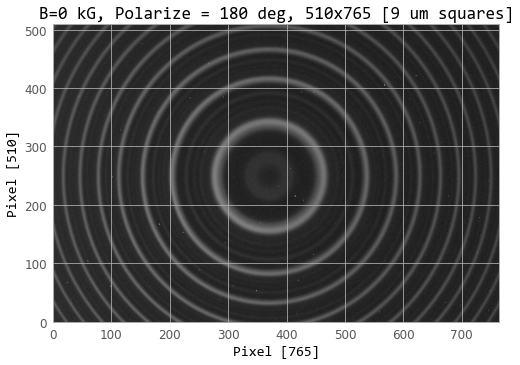

In [3]:
run1, run1_data, run1_info = GetImage('180NoBRun1Image.fit')
PlotRings(run1_data, 'B=0 kG, Polarize = 180 deg, 510x765 [9 um squares]', 'Pixel [765]', 'Pixel [510]')


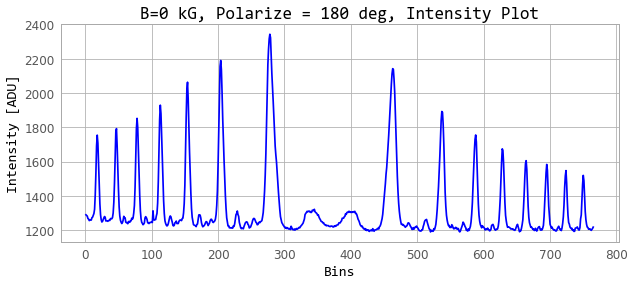

In [4]:
bins, intensities  = CreateData('180NoBRun1.txt')
bins, intensities =  np.array(bins), np.array(intensities)
Plots(bins, intensities, "B=0 kG, Polarize = 180 deg, Intensity Plot", 'Bins', 'Intensity [ADU]')
ptru, xdata, ydata = LabelPeaks_ShrinkData(bins, intensities, 100, 650, 1400)



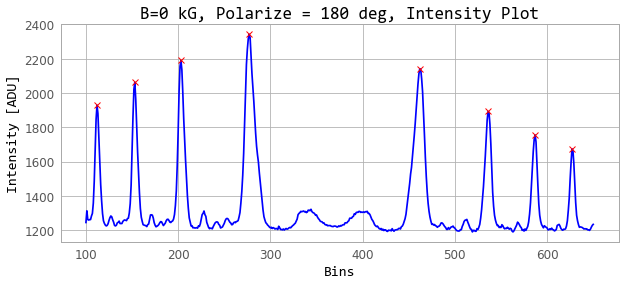

In [6]:
Plots(xdata, ydata,"B=0 kG, Polarize = 180 deg, Intensity Plot", 'Bins', 'Intensity [ADU]')
PlotNewPeaks(ptru, intensities)


In [37]:
p0 = []
for i in range(0,1): 
    p = np.zeros(len(ptru))
    p = np.random.uniform(0.2,0.3)
    p0.append(p)
    print(p)
params, peaktru = PeakBinValuesbyfit(ZeemanPeakfit, xdata, ydata, ptru, intensities, 10, 1, p0 = p0)

IndexError: list index out of range

In [14]:
print(intensities[ptru])
print(ptru)

[1929 2063 2190 2343 2142 1892 1755 1674]
[112, 153, 203, 277, 462, 536, 587, 627]


In [ ]:
radius_values = RadiusValuesInner_to_Outer(peakbins)
print(radius_values)

[ 825.219  1874.1105 1951.677  2318.2785]
